## ResNeXt

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [2]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, \
                                MaxPooling2D, AveragePooling2D, \
                                BatchNormalization, add, Resizing

### ResNet VS ResNeXt block

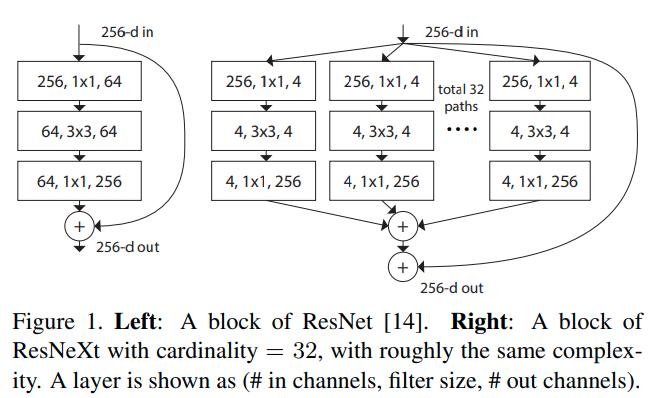

In [3]:
Image('image/resnext_fig1.png')

### ResNet block

In [4]:
def res_conv(filters, kernel_size=3, padding='same', 
             strides=1, activation=True):
    def layer_fn(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                     padding=padding, strides=strides)(x)
        x = BatchNormalization(axis=-1)(x)
        if activation:
            x = Activation('relu')(x)
        return x
    return layer_fn

In [5]:
def merge_with_shortcut():
    def layer_fn(x, x_residual):
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2])) # horizontal stride    
            )
            x_residual_channels = x_residual_shape[3]
            
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=1, 
                padding='valid', strides=strides)(x)
        
        return add([shortcut, x_residual])
    return layer_fn

In [6]:
def resnet_block(filters, kernel_size=3, strides=1,
                name='resnet_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters/4, kernel_size=1,
                    padding='valid', strides=strides)(x)
        x_residual = res_conv(filters=filters/4, kernel_size=kernel_size,
                    padding='same', strides=1)(x_residual)
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [7]:
def resnet_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = resnet_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [8]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

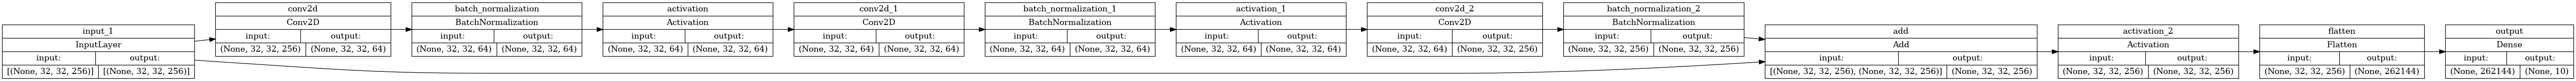

In [9]:
model = resnet_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

dot_img_file = 'ResNet_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')

### ResNeXt block

In [10]:
def resnext_block(filters, kernel_size=3, strides=1,
                 name='resnext_block'):
    def layer_fn(x):
        residual_groups = []
        for _ in range(32):
            x_residual = res_conv(filters=4, kernel_size=1,
                        padding='valid', strides=strides)(x)
            x_residual = res_conv(filters=4, kernel_size=kernel_size,
                        padding='same', strides=1)(x_residual)
            x_residual = res_conv(filters=filters, kernel_size=1,
                        padding='valid', strides=1, activation=False)(x_residual)
            residual_groups.append(x_residual)
        
        x_residual = add(residual_groups)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [11]:
def resnext_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = resnext_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [12]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

In [13]:
model = resnext_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

dot_img_file = 'ResNext_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')

## Base Idea

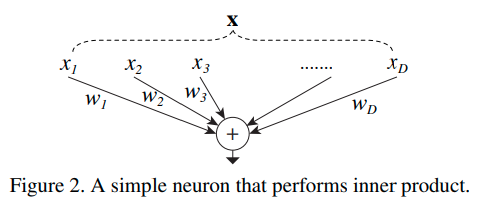

In [14]:
Image('image/resnext_fig2.png')

* inner product 를 수행하는 NN 의 가장 간단한 연산을 splitting, transforming, aggregating 의 조합으로 생각해볼 수 있습니다.
    - Splitting : 벡터 $x$ 가 저차원 임베딩으로 쪼개집니다. (1차원 subspace $x_i$)
    - Transforming : 저차원 표현이 변환됩니다. (단순히 스케일된 $w_i x_i$)
    - Aggregating : 모든 임베딩의 변환이 집계됩니다. ($\sum_{i=1}^D w_i x_i)$
* 위와 같이 간단한 neuron 에서의 분석을 기반하여 $w_i x_i$ 를 보다 일반적인 함수로 대체하는 걸 고려해볼 수 있습니다.

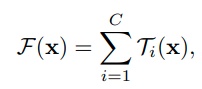

In [15]:
Image('image/resnext_eq2.png')

* 임의의 함수 $\mathcal{T}_i(x)$ 는 x 를 임베딩에 투영한 다음 x 변환해야합니다.
* C(cardinality)는 집계할 변환 집합의 크기입니다. (실험적으로 cardinality 가 매우 중요한 차원이며, width 와 depth 차원보다 더 효율적일 수 있다는 것을 확인했습니다.)


* 본 논문에서는 $\mathcal{T}_i(x)$ 를 모두 같은 topology 로 설계하여 transformation function 을 단순화하는 것을 고려하였습니다.
* $\mathcal{T}_i(x)$ 를 Fig.1 (right) 에서 묘사된 bottleneck 구조로 설정하였고, 이때 첫번째 1x1 layer 가 low-dimensional 임베딩을 수행합니다.

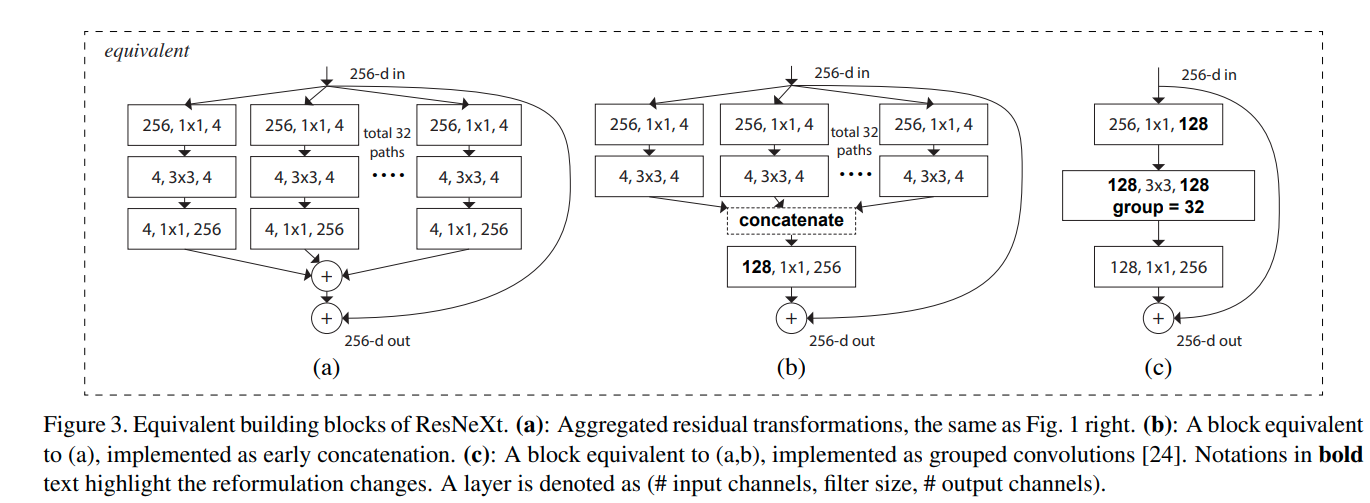

In [16]:
Image('image/resnext_fig3.png')

* ResNeXt 에서는 Grouped Convolutions 을 사용하여 (a) 와 (b) 보다 간결한 (c) 모듈을 사용합니다.

### Grouped Convolutions

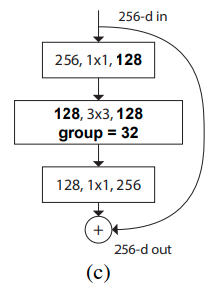

In [17]:
Image('image/resnext_fig3_c.png')

In [18]:
def group_res_conv(filters, cardinality=32, kernel_size=3, padding='same', 
             strides=1, activation=True):
    def layer_fn(x):
        x = Conv2D(filters=filters, 
                   kernel_size=kernel_size,
                   padding=padding, 
                   strides=strides,
                   groups=cardinality)(x)
        x = BatchNormalization(axis=-1)(x)
        if activation:
            x = Activation('relu')(x)
        return x
    return layer_fn

In [19]:
def group_conv_block(filters, kernel_size=3, strides=1,
                 name='group_conv_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters/2, kernel_size=1,
                    padding='valid', strides=1)(x)
        x_residual = group_res_conv(filters=filters/2, kernel_size=kernel_size,
                    padding='same', strides=strides)(x_residual)
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [20]:
def group_conv_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = group_conv_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [21]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

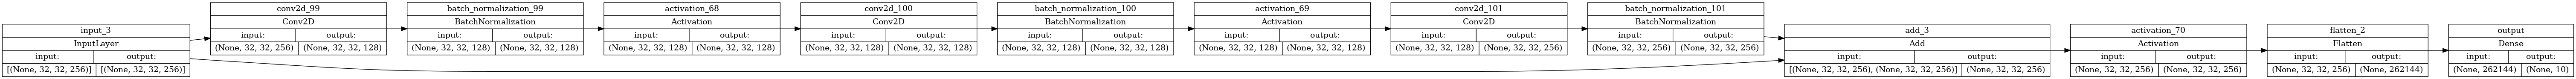

In [22]:
model = group_conv_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

dot_img_file = 'group_conv_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')

## ResNeXt Architecture

### Implementation details
* conv3,4,5 각 stage 의 제일 처음 block 의 3x3 layer 에서 stride 2 를 통한 downsampling 진행
* optimizer : SGD
* batch-size : 256, GPU : 8
* weight decay : 0.0001, momentum : 0.9, 
* learning_rate : 0.1, learning rate decay : 0.1 for three times
* 각 convolution 뒤에는 batch normalization 적용
* shortcut 과의 덧셈 후에 ReLU 가 수행되는 block 의 output 을 제외한 모든 batch normalization 뒤에 ReLU 적용
* Fig3 의 a,b,c 방법 모두 동일한 결과를 보여주므로 더 간결하고 빠른 c 방법을 선택하여 구현

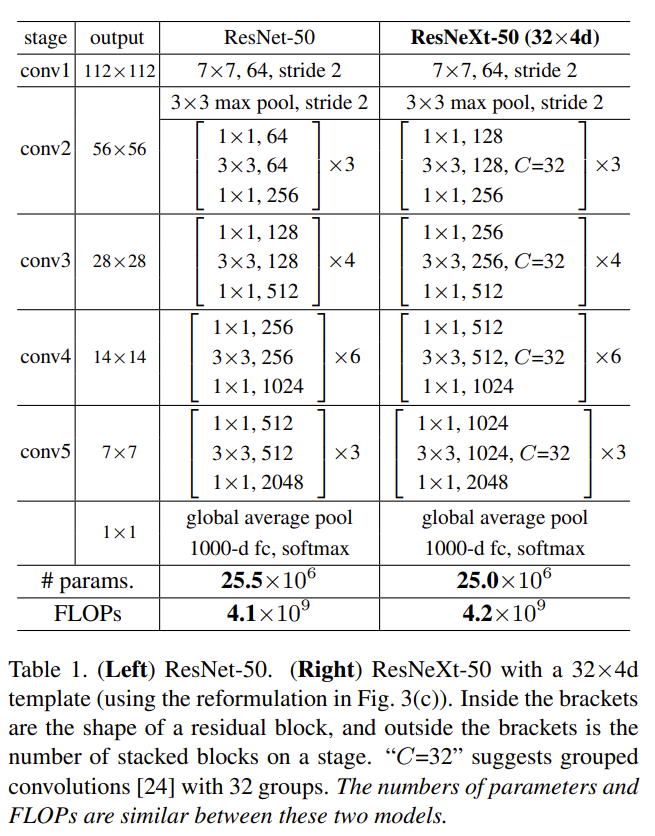

In [23]:
Image('image/resnext_table1.png')

In [24]:
def resnext_block(filters, kernel_size=3, strides=1, name='resnext_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters/2, kernel_size=1,
                    padding='valid', strides=1)(x)
        x_residual = group_res_conv(filters=filters/2, kernel_size=kernel_size,
                    padding='same', strides=strides)(x_residual)
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [25]:
def ResNeXt(input_shape, num_classes, repetitions, start_filters=64):
    filters = start_filters
    
    input = Input(shape=input_shape)

    x = res_conv(filters=filters, kernel_size=7, strides=2, padding='same')(input)
    
    filters *= 4
    
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    for i, repeat in enumerate(repetitions):
        strides_1st = 1 if i == 0 else 2
        for j in range(repeat):
            strides = strides_1st if j == 0 else 1
            x = resnext_block(filters=filters, kernel_size=3, strides=strides)(x)
        filters = min(filters * 2, 2048)
    
    block_output_shape = tf.keras.backend.int_shape(x)[1:3]
    x = AveragePooling2D(pool_size=block_output_shape, strides=1)(x)
    output = Dense(units=num_classes, activation='softmax')(x)
    
    model = Model(inputs=input, outputs=output)
    
    return model

In [26]:
num_classes = 10
input_shape = [224, 224, 3]
batch_input_shape = tf.TensorShape((None, *input_shape))

In [27]:
model = ResNeXt(input_shape, num_classes, repetitions=(3,4,6,3))
model.build(input_shape=batch_input_shape)

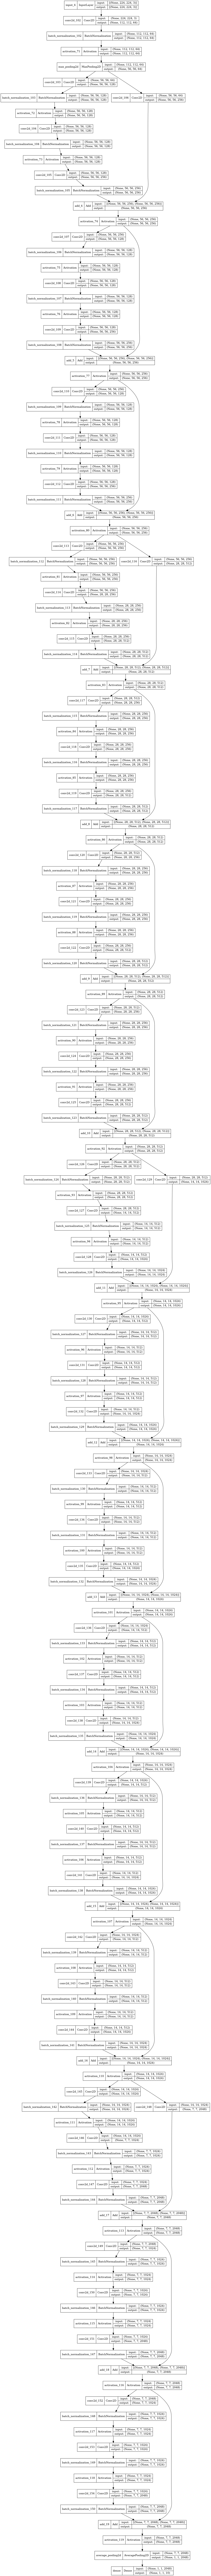

In [28]:
dot_img_file = 'ResNeXt.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Training Example

In [29]:
batch_size = 32      
num_epochs = 10

In [30]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
                                                                
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=[accuracy_metric, top5_accuracy_metric])

In [31]:
import os

model_dir = './models/resnext'

def scheduler(epoch, lr):
    if epoch % 2 == 0:
        return lr * 0.9
    else:
        return lr

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_acc',
                                    restore_best_weights=True),
    
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

## Training data load

In [32]:
import tensorflow_datasets as tfds

In [33]:
cifar_builder = tfds.builder("cifar10")
cifar_builder.download_and_prepare()

In [34]:
# Train/val Datasets:
train_dataset = cifar_builder.as_dataset(split=tfds.Split.TRAIN)
val_dataset = cifar_builder.as_dataset(split=tfds.Split.TEST)

# Number of classes:
num_classes = cifar_builder.info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_builder.info.splits['train'].num_examples
num_val_imgs = cifar_builder.info.splits['test'].num_examples

In [35]:
def _prepare_data_fn(features, input_shape, augment=False):
    
    input_shape = tf.convert_to_tensor(input_shape)
    
    image = features['image']
    label = features['label']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32) # 데이터 타입 변환, normalize 진행
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))

    return image, label

In [36]:
import functools

prepare_data_fn_for_train = functools.partial(_prepare_data_fn,
                                                input_shape=input_shape,
                                                augment=True)
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                            input_shape=input_shape,
                                            augment=False)

train_dataset = train_dataset.repeat(num_epochs) \
                        .shuffle(num_train_imgs) \
                        .map(prepare_data_fn_for_train, num_parallel_calls=4) \
                        .batch(batch_size) \
                        .prefetch(1)

val_dataset = val_dataset \
                    .repeat(num_epochs) \
                    .map(prepare_data_fn_for_val, num_parallel_calls=4) \
                    .batch(batch_size) \
                    .prefetch(1)

## Training

In [ ]:
import math

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

regularized_history = model.fit(train_dataset,
                    epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                    validation_data=(val_dataset),
                    validation_steps=val_steps_per_epoch,
                    verbose=1, callbacks=callbacks)